# <u>Effects of Concrete Mixtures and Aging on Concrete Breaking Strength</u>

#### Matthew Williams, PE

### 1. Introduction

Concrete mixes are designed to produce a specific breaking strength. A breaking strength is the pressure required to break a concrete sample. Concrete increases in strength during the curing process and beyond. Different strengths are achieved by varying the "ingredients" in a concrete mix. These include cement, slag, fly ash, water, superplasticizer, and aggregate.

This analysis looks at the concrete breaking strengths at the industry standard 28 day breaking strengths for low, medium, and high breaking strengths (relative to the data set) to determine the average concentrations of each ingredient for each classification.

Further, this analysis will look at how much the concrete samples increased in strength beyond their 28 day design strength. Even though this additional strength is generally counted on in the design of concrete structures, it is important to understand what kind of over-strength (buffer) the concrete will develop.

### 2. Analysis Tools

This analysis was developed using Python 3.11 and utilizes the following libraries:

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

### 2. The Data

The dataset used in this analysis is published by UC Irvine and is available here: https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength

It contains 1030 records with 9 attributes.

#### Import the Data

In [ ]:
drive.mount('/content/drive/')

# Read the data from csv file
concrete_data = pd.read_csv('../content/drive/MyDrive/Colab/concrete_data.csv')

# Rename 'blast_furnace_slag' & 'concrete_compressive_strength' for easier reading and referencing
concrete_data = concrete_data.rename(columns = {'blast_furnace_slag': 'slag', 'concrete_compressive_strength': 'strength'})

Mounted at /content/drive/


#### Exploring the Data

To start the exploration process, the first 7 records are displayed to see how the data is organized.

In [ ]:
# Preview dataset
concrete_data.head(7)

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70


#### Explanation of Attributes

    (all mix components are reported in units of kilograms per cubic meter of concrete mix)
    Cement: the binding agent that holds concrete together
    Slag: used to improve concrete workability and strength and also reduce permeability
    Fly Ash: used to improve concrete workability and strength and also reduce permeability
    Water: hydrates the cement and sets off the chemical process of curing
    Superplasticizer: an additive used to increase concrete strength and reduce the amount of water used
    Coarse Aggregate: gravel or crushed stone to provide strength and durability
    Fine Aggregate: sand used to fill voids and reduce the amount of cement required
    Age: days since concrete was mixed
    Strength: pressure applied to concrete sample at the time of rupture (MPa)

When a mix is created for a particular project, a number of cylinderical forms will be filled with the concrete mix. Every so often, as the concrete cures, these cylinders are crushed to measure their breaking strength over time.

Looking at the first handful of records above, mixes 2 and 3 both have the same mix. The only differences between these two records is their age and breaking strength. Thus, the dataset may contain time histories of at least some of the mixes which will allow for the calculation of strength increases over time. The latter part of this analysis will group concrete mixes by their recipe so that the amount of strength development beyond day 28 can be determined.

The next step in exploring this dataset is to determine if there are any null values that will have to be dealt with.

In [ ]:
# Check for null values
concrete_data.isna().sum()

,0
cement,0
slag,0
fly_ash,0
water,0
superplasticizer,0
coarse_aggregate,0
fine_aggregate,0
age,0
strength,0


As shown above, there are no null values. Thus, the full dataset will be used for analysis.

To get an idea of what the distribution of attribute values, use pandas "describe".

In [ ]:
# Show statistics of each attribute
concrete_data.describe()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


### 3. Hypytheses

1. Concrete mix strengths will primarily be a function of cement and water content. Higher strength concrete will be associated with higher cement content and lower water content.

2. Breaking strengths will incraease over time beyond their 28 day strength by around 10%.

### 4. Concrete Mix Analysis

Given that concrete mixes increase in strength over time, only break strengths of the same age should be compared. In the civil engineering industry, concrete is characterized by its 28 day breaking strength. This is the strength that is used in the design of concrete structures even though the concrete will continue to strengthen over time. As such, 28-day strengths will be used here for the comparison of mixes.

#### 28 Day Breaking Strength Statistics

In [ ]:
# Save 28 day data to a new dataframe
day_28_data = concrete_data.loc[concrete_data['age'] == 28].copy()

# Print 28 day statistics
print('\n28 Day Breaking Strengths (MPa)')
print('='*31 + '\n')
print('{:20s} {:>10.2f}'.format('Minimum:', day_28_data['strength'].min()))
print('{:20s} {:>10.2f}'.format('Maximum:', day_28_data['strength'].max()))
print('{:20s} {:>10.2f}'.format('Average:', round(day_28_data['strength'].sum() / len(day_28_data), 2)))
print('{:20s} {:>10.2f}'.format('Standard Deviation:', round(day_28_data['strength'].std(),2)))
print('{:20s} {:>10.0f}'.format('Record Count (qty):', len(day_28_data)))


28 Day Breaking Strengths (MPa)

Minimum:                   8.54
Maximum:                  81.75
Average:                  36.75
Standard Deviation:       14.71
Record Count (qty):         425


The above statistics show a range of design strengths from 8.5 MPa to 81.8 MPa. In English units these are 1,200 psi and 11,900 psi breaking strengths. This is a wide range of breaking strengths. A breaking strength of 1,200 psi is very low. Lower than what is required for most concrete structures. At the other end of the range, 11,900 psi concrete is quite high and would be used for structures pushing the limits of what can be built with concrete.

Below is a histogram illustrating the range and frequency of all cylinders broken at day 28 within the dataset.

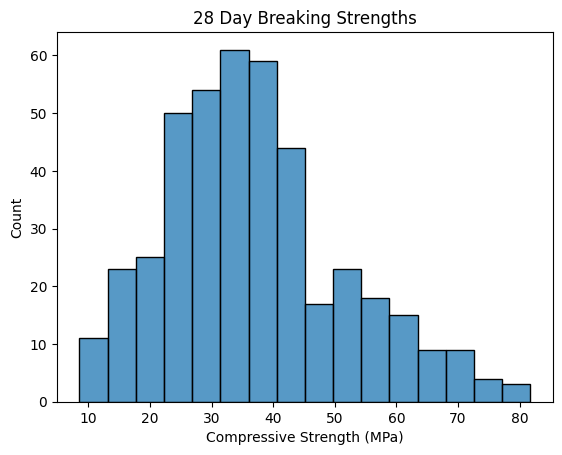

In [ ]:
# Create a histogram of 28 day breaking strengths

ax = sns.histplot(data = day_28_data['strength'])
plt.xlabel('Compressive Strength (MPa)')
plt.title('28 Day Breaking Strengths')
plt.show()

Looking at the histogram above, the most common breaking strengths are between 25 MPa and 45 MPa. For the purposes of this analysis the concrete strengths will be classified as follows:

    Low strength breaks:    less than 25 MPa
    Medium strength breaks: 25 MPa to 45 MPa
    High breaks:            above 45 MPa

The first test of the above stated hypothesis is to look at how each ingredient in the concrete mix correlates with the strength of the concrete. To do this, the Pearson correlation method is applied to the 28-day strength dataframe. This algorithm looks at the correlation of each attribute against all of the others. However, only the correlation results for concrete strength are of interest here and are presented below.

In [ ]:
# Display correlation between each chemical & the concrete strength
day_28_data.iloc[:,:9].corr(method='pearson')['strength']

,strength
cement,0.666060
slag,0.141401
fly_ash,-0.269444
water,-0.398565
superplasticizer,0.213379
coarse_aggregate,-0.120306
fine_aggregate,-0.138016
age,NaN
strength,1.000000


Correlation is reported on a scale of 1.0 down to -1.0. A value of 1.0 indicates a perfectly linear correlation and the +/- sign indicates whether the correlation is positive or negative.

Of all of the ingredients that go into the concrete mixes, cement has the strongest correlation at +0.67. The positive sign of this coefficient indicates that the correlation is positive and thus concrete strength increases with increased cement content. This supports part of the first hypothesis that higher cement ratios will be associate with higher strength mixes.

The remaining correlation coefficients are less than 0.5 and are thus not very well correlated to the strength of the concrete. Water has the second strongest correlation coefficient at -0.39.

While water is not very well correlated to concrete strength it is notable that the correlation is negative, indicating that higher concentrations of water are seen in lower strength breaks and lower concentrations of water are seen in higher strength breaks. This supports the second part of the first hypothesis

#### Classify 28 day breaks as high, medium, and low strength

To get an understanding of how concrete mixes differ among different strengths of concrete, the mixes can be classified as low, medium, and high strengths per the ranges determined above. In the code below, a new column is added to the day_28_data DataFrame with these classifications.

In [ ]:
# Add a column for break_class and set all samples to medium, 'med', strength
day_28_data['break_class'] = 'med'

# Update break_class for all records with a strength less than 25 MPa
day_28_data.loc[day_28_data['strength'] < 25, 'break_class'] = 'low'

# Update break_class for all reacords with a strength greater than 45 MPa
day_28_data.loc[day_28_data['strength'] > 45, 'break_class'] = 'high'

# Preview new column
day_28_data.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength,break_class
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,high
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,high
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45,med
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,high
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29,med


Now that the mixes have been classified, box plots of each classification can be created to visually illustrate how the classes differ from one another.

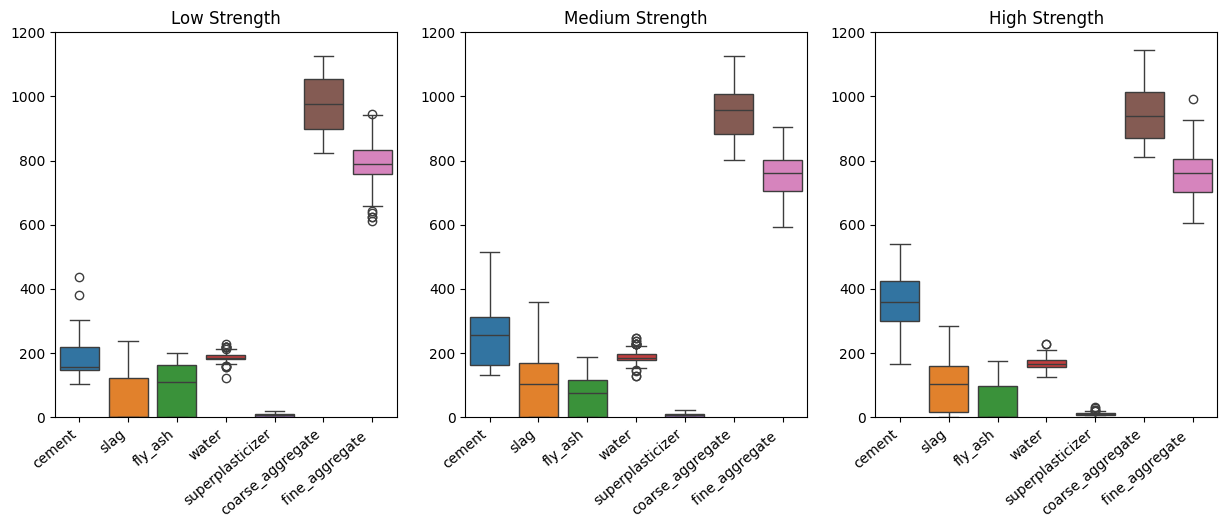

In [ ]:
# Box plots of concrete mixes
low_28day_breaks = day_28_data.loc[(day_28_data['break_class'] == 'low')]
med_28day_breaks = day_28_data.loc[(day_28_data['break_class'] == 'med')]
high_28day_breaks = day_28_data.loc[(day_28_data['break_class'] == 'high')]

# Create a figure with 3 subplots, one for each class
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.boxplot(low_28day_breaks.iloc[:,0:7], ax = axs[0]).set(title='Low Strength', ylim=(0,1200))
sns.boxplot(med_28day_breaks.iloc[:,0:7], ax = axs[1]).set(title='Medium Strength', ylim=(0,1200))
sns.boxplot(high_28day_breaks.iloc[:,0:7], ax = axs[2]).set(title='High Strength', ylim=(0,1200))

# Rotate & align x labels
for i in np.arange(3):
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=40, ha='right')

plt.show()

The above plots confirm the hypothesis and correlation coefficients. The average cement content increases from low to medium to high strength concretes. Water content appears to decrease from one class to the next as well. It is not clear from these plots how the remaining ingredients vary from mix to mix.

To get an idea of this, the average values for all ingredients can be compared as shown in the table below.

In [ ]:
# Create a DataFrame of average mix contents
columns = low_28day_breaks.columns                # list of all column names
columns = columns.drop(['age', 'break_class'])    # remove unwanted columns

# Populate DataFrame with average ingredient amounts by class
summary_df = pd.DataFrame(low_28day_breaks[columns].sum()/len(low_28day_breaks)).transpose()
summary_df = pd.concat([summary_df, pd.DataFrame(med_28day_breaks[columns].sum()/len(med_28day_breaks)).transpose()])
summary_df = pd.concat([summary_df, pd.DataFrame(high_28day_breaks[columns].sum()/len(high_28day_breaks)).transpose()])

summary_df['Strength Class'] = ['Low', 'Med', 'High']   # add a column with the strength class
summary_df = summary_df.set_index('Strength Class')     # set strength class as the index

# Display DataFrame
print('\nAverage Mix Contents')
summary_df.round(1)


Average Mix Contents


,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,strength
Strength Class,,,,,,,,
Low,184.0,54.3,87.9,188.2,6.3,979.3,787.7,18.9
Med,254.8,95.8,61.7,187.0,6.2,951.1,757.3,34.7
High,365.9,92.6,42.4,168.8,9.6,946.8,760.1,58.1


The average cement content increased with higher strength concrete mixes while fly ash, water, and coarse aggregate decreased with higher strength concretes.

# 5. Strength Development Past 28 Days

While concrete is designed and mixed to achieve a minimum 28-day strength, concrete strength continues to increase past the 28 day mark. During the data exploration, it was found that at least two records shared the same mix. In order to determine how concrete mixes age past 28 days, the mixes will have to be grouped by their ingredient contents.

The dataset does not include batch numbers or mix identifiers that would make this grouping straight forward. As such, a unique recipe identifier must be created from the data and then used to group the samples.

#### Identify the Different Mixes

To create a unique identifier for a mix recipe, the values for each ingredient are converted to a text string and then concatenated. This produces a unique string of numbers and periods "." for each recipe. An example output can be seen below.

In [ ]:
# Concatenate mix ingredients as strings to create a unique mix identifier
concrete_data['mix_as_string'] = concrete_data['cement'].astype(str) + concrete_data['slag'].astype(str) + \
                                 concrete_data['fly_ash'].astype(str) + concrete_data['water'].astype(str) + \
                                 concrete_data['superplasticizer'].astype(str) + concrete_data['coarse_aggregate'].astype(str) + \
                                 concrete_data['fine_aggregate '].astype(str)

# Print example strings
print('\n Example mix strings used as indicies:\n')
concrete_data['mix_as_string'].iloc[:3]


 Example mix strings used as indicies:



,mix_as_string
0,540.00.00.0162.02.51040.0676.0
1,540.00.00.0162.02.51055.0676.0
2,332.5142.50.0228.00.0932.0594.0


#### Count of Unique Concrete Mixes

In [ ]:
# Find number of concrete mixes
print('\nNumber of unique concrete mixes:', len(concrete_data['mix_as_string'].unique()))


Number of unique concrete mixes: 427


A total of 427 concrete mixes were included in this dataset. Given that there are 1030 records in total, there should be a number of mixes that include several breaks at different ages.

#### Number of Breaks by Age

In order to maximize the number of records used in calculating the average strength increase beyond 28 days, look at the number of breaks for each unique age in the dataset.

In [ ]:
unique_ages = concrete_data['age'].unique() # create a list of unique sample ages
unique_ages.sort()                          # sort the list in ascending order

# Print the number of samples tested for each unique age
print('\nAge', 'Count')
print('='*9)
for i in unique_ages:
    print('{:<4d} {:>4d}'.format(i, len(concrete_data['age'].loc[concrete_data['age'] == i])))


Age Count
1       2
3     134
7     126
14     62
28    425
56     91
90     54
91     22
100    52
120     3
180    26
270    13
360     6
365    14


The oldest samples were broken at day 365. While still relatively young as far as structure ages go, it will give the best results within this dataset as to how concrete matures. With 14 records a range of strength values will be averaged.

#### Preparing DataFrames for Broadcasting Calculations

The most straight forward way to perform the strength increase calculations is to use broadcasting. To do this, though, the mix_as_string identifiers created for each record will need to be used as the index of the DataFrame.

In [ ]:
# Set mix_as_string as the index to support calculations by broadcasting
concrete_data = concrete_data.set_index('mix_as_string')

# Verify changes
concrete_data.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
mix_as_string,,,,,,,,,
540.00.00.0162.02.51040.0676.0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
540.00.00.0162.02.51055.0676.0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
332.5142.50.0228.00.0932.0594.0,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
332.5142.50.0228.00.0932.0594.0,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
198.6132.40.0192.00.0978.4825.5,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


With the index now set as the mix string DataFrames for day 28 and day 365 strengths will now be created. These new DataFrames will then be used to calculate the percentage of strength increase relative to day 28 for each record that has both 28 day and 365 day breaks.

In [ ]:
# Create new dataframes, one for 28 day breaks and one for 365 day breaks
day_28_mixes = concrete_data.loc[concrete_data['age'] == 28].copy()
day_365_mixes = concrete_data.loc[concrete_data['age'] == 365].copy()

# Calculate strength difference between 365 and 28 day breaks
delta = (day_365_mixes['strength'] - day_28_mixes['strength']).dropna()

# Calculate strength increase from original strength as a percentage of the original strength
strength_increase = pd.DataFrame((delta / day_28_mixes['strength']).dropna()*100)
strength_increase = strength_increase.rename(columns = {'strength': 'Strength Increase'})
print('\nStrength Increases as a Percentage From Day 28\n')
strength_increase


Strength Increases as a Percentage From Day 28



,Strength Increase
mix_as_string,
190.0190.00.0228.00.0932.0670.0,31.399902
237.5237.50.0228.00.0932.0594.0,29.654255
266.0114.00.0228.00.0932.0670.0,15.398037
304.076.00.0228.00.0932.0670.0,15.582514
307.00.00.0193.00.0968.0812.0,31.311297
332.5142.50.0228.00.0932.0594.0,24.318595
339.00.00.0197.00.0968.0781.0,21.379526
380.095.00.0228.00.0932.0594.0,19.890261
427.547.50.0228.00.0932.0594.0,16.751269


#### Calculate & Display Summary Statistics

In [ ]:
# Summarize strength increases beyond day 28
print('\nStrength Increase from Day 28 to Day 365 (%)')
print('='*44 + '\n')
print('{:33s} {:>10.1f}'.format('Maximum Increase:', strength_increase['Strength Increase'].max()))
print('{:33s} {:>10.1f}'.format('Minimum Increase:', strength_increase['Strength Increase'].min()))
print('{:33s} {:>10.1f}'.format('Average Increase:', strength_increase['Strength Increase'].sum() / len(strength_increase), 2))


Strength Increase from Day 28 to Day 365 (%)

Maximum Increase:                       31.4
Minimum Increase:                        6.7
Average Increase:                       21.2


# 6. Findings

The first part of this analysis has confirmed the hypothesis that concrete strenths will increase with higher concentrations of cement and lower concentrations of water. It has also shown that fly ash and coarse aggregate concentrations also decreased as concrete strength increases. No clear pattern was discerned for slag, superplasticizer, or fine aggregate.

Breaking strenths were shown to increase over time, as expected. However, the second hypothesis that the sample strengths would increase an average of 10% was shown to be too low. Strengths increased an average of 21.2% from day 28 to day 365, the longest time interval in the dataset. It should be noted that the sample size is only 14 records and the elapsed time is only 337 days. To get a better understanding of how concrete age increases relative to typical structure design lifes, more records would be needed and the age difference should be extended from days to years.